A closed budget for the carbon inventory (total carbon in each grid cell), accounting for variations in the sea surface height

In [1]:
import xarray as xr
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

In [2]:
rootdir = '/local/data/bSOSE/'
niter = 'iter133NEW'
freq = '5day'
chunks = 1

### CARBON CONCENTRATION BUDGET ###
# Load all carbon tendencies and fluxes
filenames = 'bsose_i133_2013to2018_5day_*C.nc'
ds = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
# Load surface carbon flux
filenames = 'bsose_i133_2013to2018_5day_surfCO2flx.nc'
ds_surf = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
# Load carbon snapshots
filenames = 'bsose_i133_2013to2018_5daySnapShots_DIC.nc'
ds_csnaps = xr.open_dataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
ds_csnaps = ds_csnaps.rename({'time':'time_snaps','TRAC01':'TRAC01_snaps'}).drop('iter')
# Specify shift of time axis for snapshots
ds_csnaps['time_snaps'].attrs['c_grid_axis_shift']=-0.5

### VOLUME BUDGET ###
# Load velocity data
filenames = 'bsose_i133_2013to2018_5day_*vel.nc'
ds_vel = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
# Load SSH
filenames = 'bsose_i133_2013to2018_5day_SSH.nc'
ds_ssh = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
# Load SSH snapshots
filenames = 'bsose_i133_2013to2018_5daySnaps_SSH.nc'
ds_sshsnaps = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
ds_sshsnaps = ds_sshsnaps.rename({'time':'time_snaps','ETAN':'ETAN_snaps'}).drop('iter')
# Specify shift of time axis
ds_sshsnaps['time_snaps'].attrs['c_grid_axis_shift']=-0.5
# Load FW flux
freq = '1day'
filenames = 'bsose_i133_2013to2018_1dy_oceFWflx.nc'
ds_fw = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
ds_fw = ds_fw.coarsen(time=5,boundary='trim',keep_attrs=True).mean().assign_coords({'time':ds_vel['time']})

# Merge to full dataset
ds = xr.merge([ds,ds_csnaps,ds_vel,ds_surf,ds_ssh,ds_sshsnaps,ds_fw])

# Define vertical metrics as negative, to account for descending coordinate
ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at tracer point
# Volume
ds['vC'] = ds['drC']*ds['rA']
# Define cell side areas
ds['rAW'] = ds['dyG']*ds['drW']
ds['rAS'] = ds['dxG']*ds['drS']

# Define time metric
# HACK: trouble with time difference metric, so here just setting up own array with 5-days in seconds 
dt = xr.DataArray(432000*np.ones(shape=(438)),dims='time')
# Reference density
rho0 = 1035.0

metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}

xgrid = Grid(ds,periodic=['X'],metrics=metrics)

### Variable units
|Term        |Diag name|Units                   |
|------------|---------|------------------------|
|Advection   |ADV*Tr01 |$molC\,m^{-1} m^3s^{-1}$|
|Correction  |WTRAC01  |$molC\,m^{-1} ms^{-1}$  |
|Diffusion   |DF*Tr01  |$molC\,m^{-1} m^3s^{-1}$|
|Dilution    |ForcTr01 |$molC\,m^{-1}s^{-1}$    |
|Biology     |BLGBIOC  |$molC\,m^{-3}s^{-1}$    |
|Surface flux|BLGCFLX  |$molC\,m^{-2}s^{-1}$    |
|------------|---------|------------------------|
|SSH         |ETAN     |$m$                     |
|FW flux     |oceFWflx |$kg\,m^{-2}s^{-1}$      |
|Velocity    |*VEL     |$m\,s^{-1}$             |

In [3]:
# Define some masks
# Mask to set surface velocity point to zero
tmp = np.ones(len(ds['Zl']))
tmp[0]=0
maskZl = xr.DataArray(tmp,dims=['Zl'],coords={'Zl':ds['Zl']})

# Mask to set surface tracer point to one (everything else to zero)
tmp = np.ones(len(ds['Z']))
tmp[1:]=0
maskZ = xr.DataArray(tmp,dims=['Z'],coords={'Z':ds['Z']})

$$ \Phi = \int_{z_{i+1}}^{z_i} \phi dz $$
$z_0$ and $z_1$ are fixed except at the linear free surface, where $z_i = \eta$.
$$ \frac{\partial \Phi}{\partial t} = \phi(z_{i})\frac{\partial z_{i}}{\partial t} - \phi(z_{i+1})\frac{\partial z_{i+1}}{\partial t} + \int_{z_{i+1}}^{z_i} \frac{\partial \phi}{\partial t}$$
The first two terms go to zero everywhere except the top grid cell **[NOTE: this may not actually be true on the $z^*$ grid, where I likely have to account for temporal changes in subsurface cell thicknesses]**, where it becomes:
$$ \frac{\partial \Phi}{\partial t} = \phi(\eta)\frac{\partial \eta}{\partial t} + \int_{z_0}^{\eta} \frac{\partial \phi}{\partial t}$$
where $z_0$ is the depth of the base of the first grid cell.  
Separate the integral up to the fixed surface and the free surface: 
$$ \frac{\partial \Phi}{\partial t} = \phi(\eta)\frac{\partial \eta}{\partial t} + \int_{z_0}^{0} \frac{\partial \phi}{\partial t} + \int_{0}^{\eta} \frac{\partial \phi}{\partial t}$$

In [4]:
phidetadt = maskZ*ds['TRAC01']*xgrid.diff(ds['ETAN_snaps'],'T')/dt
hdphidt = ds['drC']*xgrid.diff(ds['TRAC01_snaps'],'T')/dt
etadphidt = maskZ*ds['ETAN']*xgrid.diff(ds['TRAC01_snaps'],'T')/dt

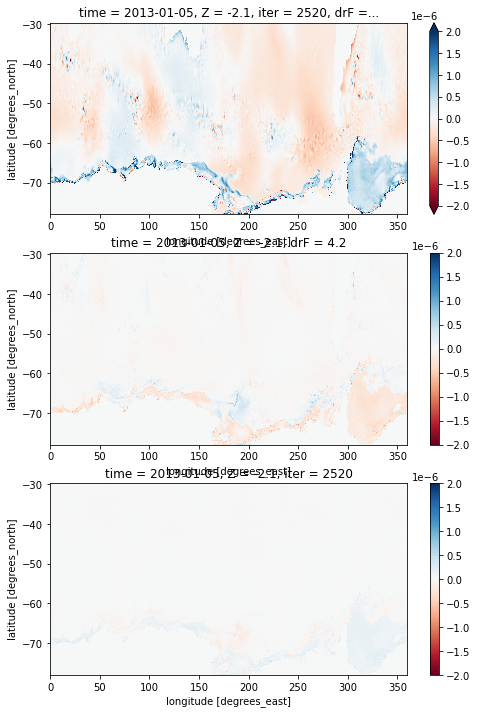

In [5]:
select = {'time':0,'Z':0}
kwargs = {'vmin':-2E-6,'vmax':2E-6,'cmap':'RdBu'}
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(8,12),nrows=3)
phidetadt.isel(select).plot(ax=ax1,**kwargs)
hdphidt.isel(select).plot(ax=ax2,**kwargs)
etadphidt.isel(select).plot(ax=ax3,**kwargs)

### Dilution
The depth-integrated dilution term should be given by the surface mass flux:
$$ hd_\phi = Q_m(\phi_m - \phi_s) $$
where $Q_m$ is the surface mass flux, $\phi_m$ is the tracer concentration in the surface mass flux, and $phi_s$ is the tracer concentration in the surface grid cell.

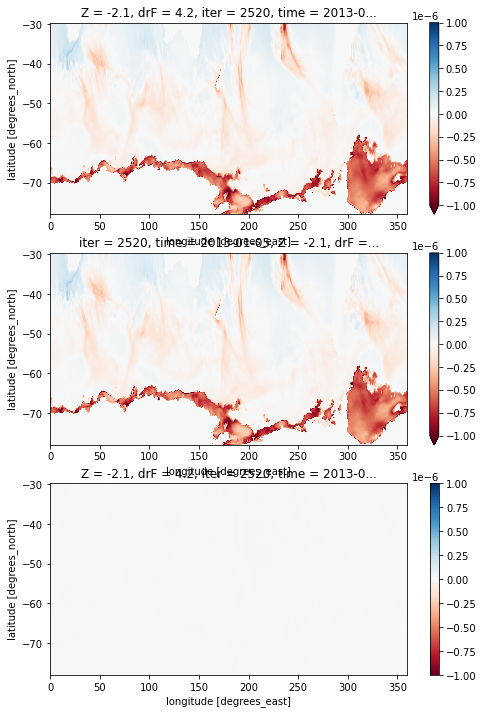

In [6]:
rho0=1035.0
h = ds['drC']#+ds['ETAN']*maskZ
LHS = h*ds['ForcTr01']
RHS = (ds['oceFWflx']/rho0)*(0-ds['TRAC01']*maskZ)
select = {'time':0,'Z':0}
kwargs = {'vmin':-1E-6,'vmax':1E-6,'cmap':'RdBu'}
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(8,12),nrows=3)
LHS.isel(select).plot(ax=ax1,**kwargs)
RHS.isel(select).plot(ax=ax2,**kwargs)
(LHS-RHS).isel(select).plot(ax=ax3,**kwargs)

### Accounting for correction and dilution terms
From the volume budget,
$$ \frac{\partial\eta}{\partial t} = w_s - \epsilon + Q_m $$
where $w_s$ is vertical velocity at the top of the fixed grid (at $z=0$) and  $Q_m$ is the freshwater flux. Here, $\epsilon$ represents the component of the vertical velocity that is derived from the large-scale pressure solver, the impact of which is not felt sea-surface height variations.
The surface correction term applied to the tracer budget can thus be written as:
$$ w_s \phi_s = (\frac{\partial\eta}{\partial t} + \epsilon - Q_m)\phi_s $$
From each side, subtract the dilution term:
$$ w_s \phi_s - hd_\phi  = (\frac{\partial\eta}{\partial t} + \epsilon - Q_m)\phi_s - Q_m(\phi_m - \phi_s)$$
$$ w_s \phi_s - hd_\phi  = (\frac{\partial\eta}{\partial t} + \epsilon)\phi_s - Q_m\phi_m$$
Since, in this model, $\phi_m=0$, it should be the case that the difference of the correction term and the dilution term are balanced by the tendency due to sea surface height changes (plus the pressure solver impact).

In [7]:
LHS = maskZ*ds['WTRAC01']-ds['drC']*ds['ForcTr01']
# Get epsilon from the residual in the volume budget
epsilon = ds['oceFWflx']/rho0 + ds['WVEL'].isel(Zl=0) - xgrid.diff(ds['ETAN_snaps'],'T')/dt
RHS = phidetadt + maskZ*epsilon*ds['TRAC01']

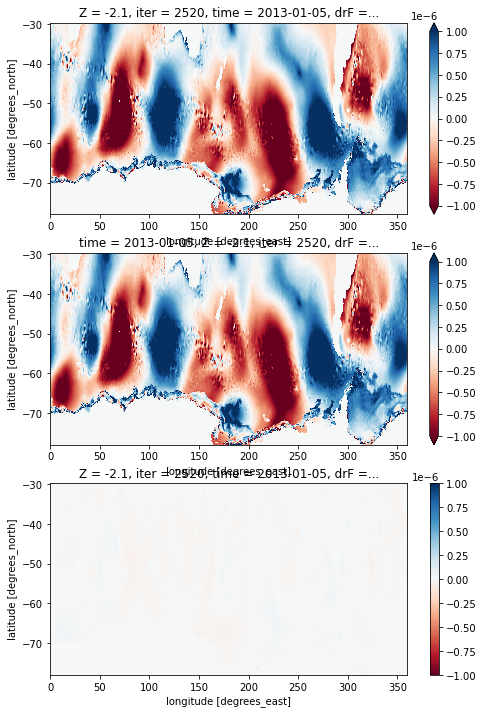

In [8]:
select = {'time':0,'Z':0}
kwargs = {'vmin':-1E-6,'vmax':1E-6,'cmap':'RdBu'}
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(8,12),nrows=3)
LHS.isel(select).plot(ax=ax1,**kwargs)
RHS.isel(select).plot(ax=ax2,**kwargs)
(LHS-RHS).isel(select).plot(ax=ax3,**kwargs)

### Balancing the content budget
The tendency of carbon inventory is comprised of two parts (see above):
$$ \frac{\partial \Phi}{\partial t} = \phi_s\frac{\partial \eta}{\partial t} + \int_{z_0}^{\eta} \frac{\partial \phi}{\partial t}$$
The integral part is balanced by the vertical integral of the concentration budget:
$$\int_{z_0}^{\eta} \frac{\partial \phi}{\partial t} = \int_{z_0}^{\eta} (ADV - CORR + DIFF +FORC + SURF + BIO)$$
The surface height variation part is balanced by the correction, dilution, and pressure solver terms:
$$\phi(\eta)\frac{\partial \eta}{\partial t} = CORR - DIFF - \epsilon \phi_s$$
Combining these, the general carbon inventory budget should be balanced as such:
$$ \frac{\partial \Phi}{\partial t} = \int_{z_0}^{\eta} (ADV + DIFF + SURF + BIO - \epsilon  \phi_s)$$
There is an open question about how to interpret and understand the pressure solver term. Expectating (hoping) that it goes to zero on some timescale (needs to be checked).

**[NOTE: I need to check the units of all of this]**

In [9]:
budget = xr.Dataset()
h = ds['drC']+ds['ETAN']*maskZ
budget['TEND'] = (phidetadt+hdphidt+etadphidt)
# Note division by AREA
budget['ADV'] = h*-1*(xgrid.diff(ds['ADVxTr01'],'X')+
                  xgrid.diff(ds['ADVyTr01'],'Y',boundary='extend')+
                  (-1*xgrid.diff(ds['ADVrTr01'],'Z',boundary='extend')))/ds['vC']
budget['DIFF'] = h*-1*(xgrid.diff(ds['DFxETr01'],'X')+
                   xgrid.diff(ds['DFyETr01'],'Y',boundary='extend')+
                   (-1*xgrid.diff(ds['DFrITr01'],'Z',boundary='extend')))/ds['vC']
budget['BIO'] = h*ds['BLGBIOC']
budget['SURF'] = maskZ*ds['BLGCFLX']
# budget['FORC'] = ds['drC']*ds['ForcTr01']
# budget['CORR'] = maskZ*ds['WTRAC01']
epsilon = ds['oceFWflx'] + rho0*ds['WVEL'].isel(Zl=0) - rho0*xgrid.diff(ds['ETAN_snaps'],'T')/dt
budget['EPS'] = maskZ*(epsilon/rho0)*ds['TRAC01']

budget['RES'] = (-1*budget['TEND']+budget['ADV']
                 +budget['DIFF']+budget['BIO']+budget['SURF']-budget['EPS'])

In [10]:
signs = {'TEND':-1,'ADV':1,'ADVcorr':1,'DIV':1,'DIFF':1,'BIO':1,'FORC':1,'CORR':-1,'SURF':1,'EPS':-1}

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


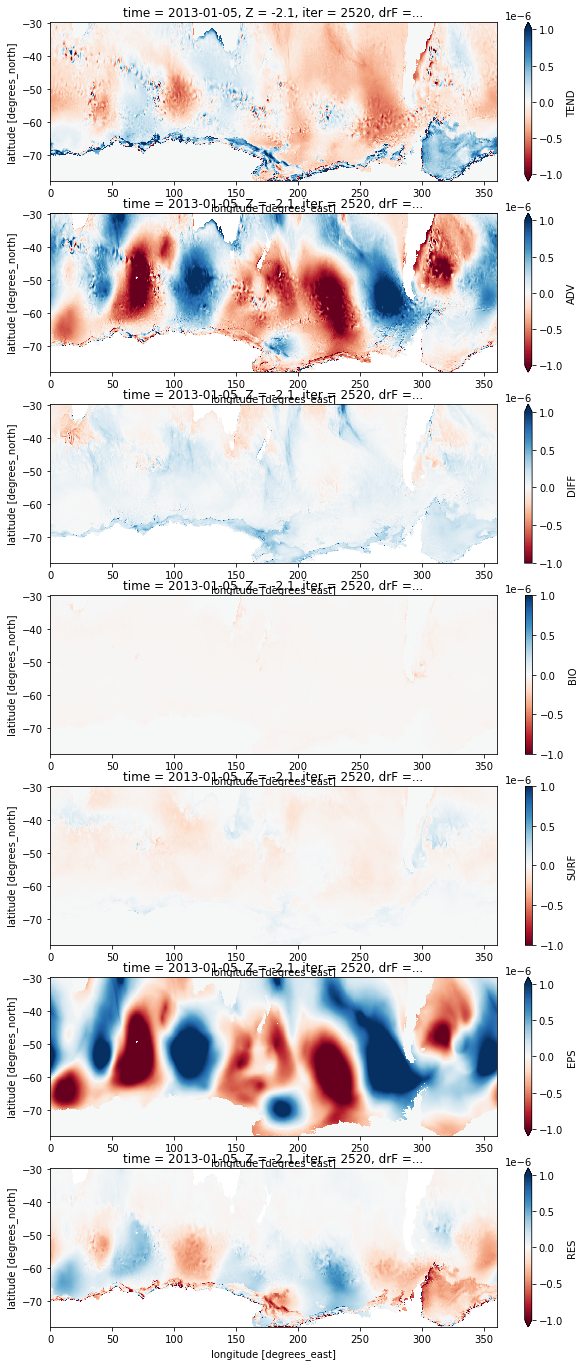

In [11]:
terms = ['TEND','ADV','DIFF','BIO','SURF','EPS']
# terms = ['TEND','ADV','DIFF','BIO','FORC','SURF']
select = {'time':0,'Z':0}
kwargs = {'vmin':-1E-6,'vmax':1E-6,'cmap':'RdBu'}
nt = len(terms)
fig,axarr=plt.subplots(figsize=(10,4*nt),nrows=len(terms)+1)
RES = xr.zeros_like(budget[terms[0]].isel(select))
RES.name = 'RES'
for i,term in enumerate(terms):
    ax=axarr.flat[i]
    budget[term].isel(select).plot(ax=ax,**kwargs)
    RES += signs[term]*budget[term].isel(select)
ax=axarr.flat[-1]    
RES.plot(ax=ax,**kwargs)

### Direct evaluation of content tendency
$$\frac{\partial \Phi}{\partial t} = \frac{\partial (h\phi)}{\partial t}$$
Snapshots of $h = \Delta z + \eta$ are provided.

In [12]:
h = ds['drC']+ds['ETAN_snaps']*maskZ
hPhi = ds['TRAC01_snaps']*h
TEND_direct = xgrid.diff(hPhi,'T')/dt
TEND_derived = phidetadt+hdphidt+etadphidt

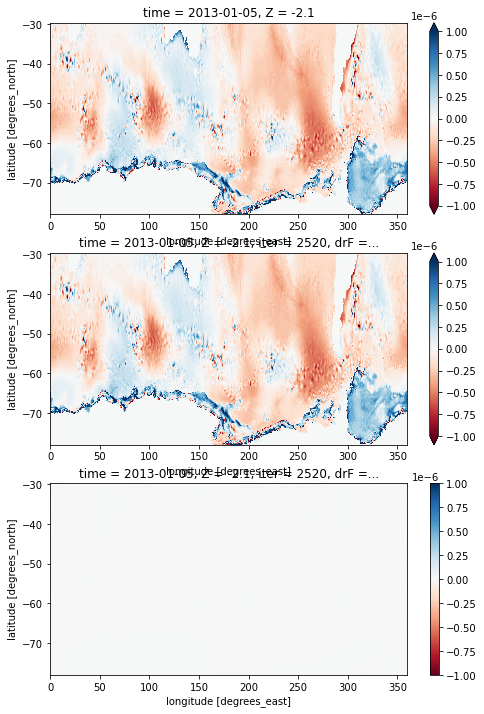

In [13]:
select = {'time':0,'Z':0}
kwargs = {'vmin':-1E-6,'vmax':1E-6,'cmap':'RdBu'}
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(8,12),nrows=3)
TEND_direct.isel(select).plot(ax=ax1,**kwargs)
TEND_derived.isel(select).plot(ax=ax2,**kwargs)
(TEND_direct-TEND_derived).isel(select).plot(ax=ax3,**kwargs)

### Integral of closed concentration budget
For concentration:
$$\frac{\partial \phi}{\partial t} = ADV - CORR + DIFF + FORC + SURF + BIO $$
So the vertical integral of these terms should also balance.

In [14]:
# Concentration budget
budgetC = xr.Dataset()
budgetC['TEND'] = xgrid.diff(ds['TRAC01_snaps'],'T')/dt
budgetC['ADV'] = -(xgrid.diff(ds['ADVxTr01'],'X')+
                  xgrid.diff(ds['ADVyTr01'],'Y',boundary='extend')+
                  (-1*xgrid.diff(ds['ADVrTr01'],'Z',boundary='extend')))/ds['vC']
budgetC['DIFF'] = -(xgrid.diff(ds['DFxETr01'],'X')+
                  xgrid.diff(ds['DFyETr01'],'Y',boundary='extend')+
                  (-1*xgrid.diff(ds['DFrITr01'],'Z',boundary='extend')))/ds['vC']
budgetC['BIO'] = ds['BLGBIOC']
budgetC['SURF'] = maskZ*(ds['BLGCFLX']/ds['drC'])
budgetC['FORC'] = ds['ForcTr01']
budgetC['CORR'] = maskZ*ds['WTRAC01']/ds['drC']
budgetC['RES'] = (-1*budgetC['TEND']+budgetC['ADV']-budgetC['CORR']
                 +budgetC['DIFF']+budgetC['BIO']
                 +budgetC['FORC']+budgetC['SURF'])

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/hom

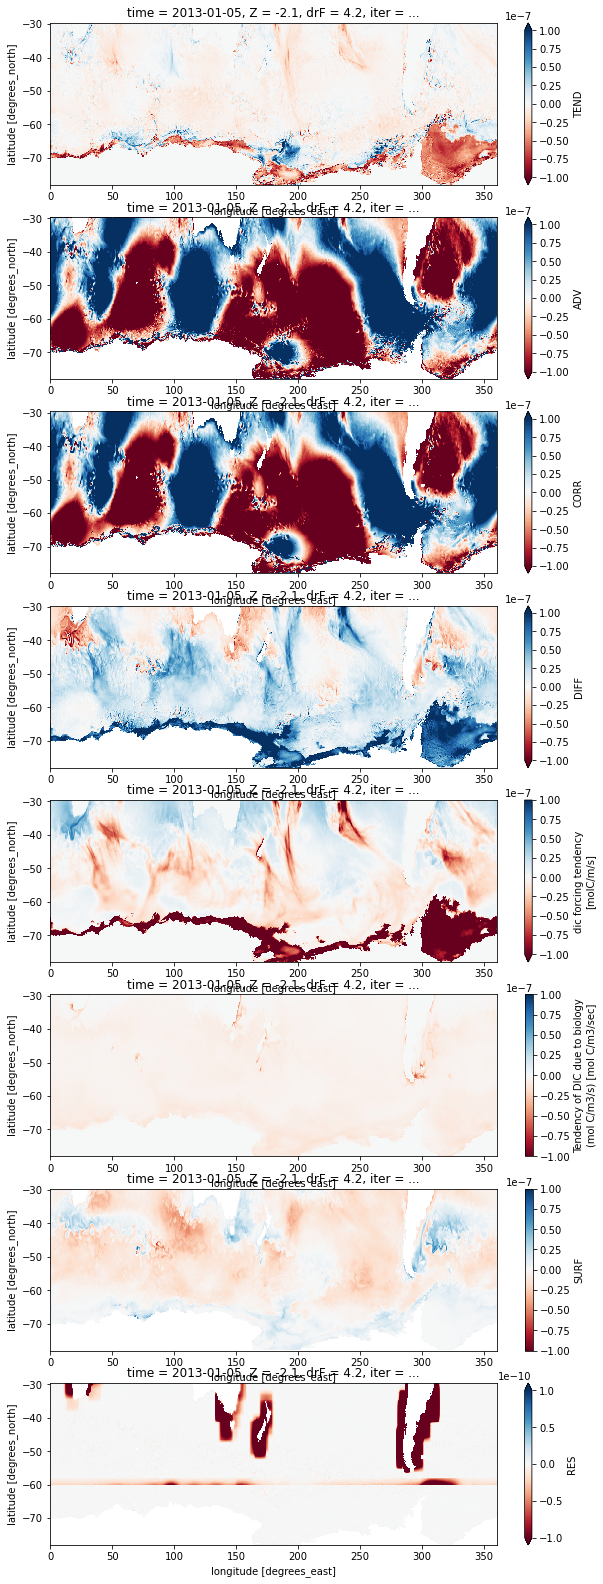

In [15]:
terms = ['TEND','ADV','CORR','DIFF','FORC','BIO','SURF']
select = {'time':0,'Z':0}
kwargs = {'vmin':-1E-7,'vmax':1E-7,'cmap':'RdBu'}
nt = len(terms)
fig,axarr=plt.subplots(figsize=(10,4*nt),nrows=len(terms)+1)
RES = xr.zeros_like(budgetC[terms[0]].isel(select))
RES.name = 'RES'
for i,term in enumerate(terms):
    ax=axarr.flat[i]
    budgetC[term].isel(select).plot(ax=ax,**kwargs)
    RES += signs[term]*budgetC[term].isel(select)
ax=axarr.flat[-1]    
RES.plot(ax=ax,vmin=kwargs['vmin']*1E-3,vmax=kwargs['vmax']*1E-3,cmap=kwargs['cmap'])

In [16]:
# 1. Tracer budget
LHS = budgetC['TEND']
RHS = budgetC['ADV'] - budgetC['CORR'] + budgetC['DIFF'] + budgetC['FORC'] + budgetC['BIO'] + budgetC['SURF']
# Multiply by fixed depth to get fixed volume content budget
LHS = LHS*ds['drF']
RHS = RHS*ds['drF']
# 2a. Add phi*deta/dt to LHS
LHS += maskZ*ds['TRAC01']*xgrid.diff(ds['ETAN_snaps'],'T')/dt
# 2b. Add its counterpart (from the volume budget) to the RHS
epsilon = ds['oceFWflx']/rho0 + ds['WVEL'].isel(Zl=0) - xgrid.diff(ds['ETAN_snaps'],'T')/dt
RHS += maskZ*ds['WTRAC01']-ds['drC']*ds['ForcTr01'] - maskZ*epsilon*ds['TRAC01']
# 3a. Add eta*dphi/dt to the LHS
LHS += maskZ*ds['ETAN']*budgetC['TEND']
# 3b. Add the variable depth component of the 
RHS += maskZ*ds['ETAN']*(budgetC['ADV'] - budgetC['CORR'] + budgetC['DIFF'] + budgetC['FORC'] + budgetC['BIO'] + budgetC['SURF'])

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/

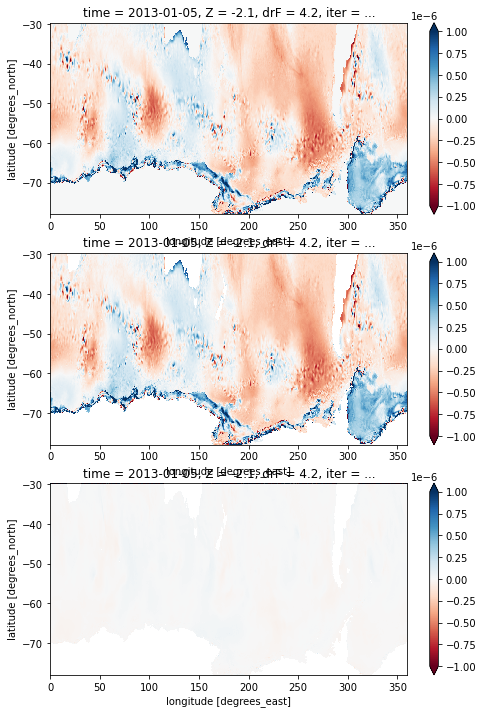

In [17]:
select = {'time':0,'Z':0}
kwargs = {'vmin':-1E-6,'vmax':1E-6,'cmap':'RdBu'}
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(8,12),nrows=3)
LHS.isel(select).plot(ax=ax1,**kwargs)
RHS.isel(select).plot(ax=ax2,**kwargs)
(LHS-RHS).isel(select).plot(ax=ax3,**kwargs)#vmin=kwargs['vmin']*1E-2,vmax=kwargs['vmax']*1E-2,cmap=kwargs['cmap'])

### Content budget

In [18]:
budget = xr.Dataset()
# Tendency
h_snaps = ds['drC']+ds['ETAN_snaps']*maskZ
hPhi = ds['TRAC01_snaps']*h_snaps
budget['TEND'] = xgrid.diff(hPhi,'T')/dt
# Terms
h = ds['drC']+ds['ETAN']*maskZ
eta = ds['ETAN']*maskZ
budget['ADV'] = h*budgetC['ADV']
budget['DIFF'] = h*budgetC['DIFF']
budget['BIO'] = h*budgetC['BIO']
budget['SURF'] = h*budgetC['SURF']
budget['CORR'] = eta*budgetC['CORR']
budget['FORC'] = eta*budgetC['FORC']
epsilon = ds['oceFWflx']/rho0 + ds['WVEL'].isel(Zl=0) - xgrid.diff(ds['ETAN_snaps'],'T')/dt
budget['EPS'] = maskZ*epsilon*ds['TRAC01']

# budget = budget.isel(time=slice(0,24))

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/hom

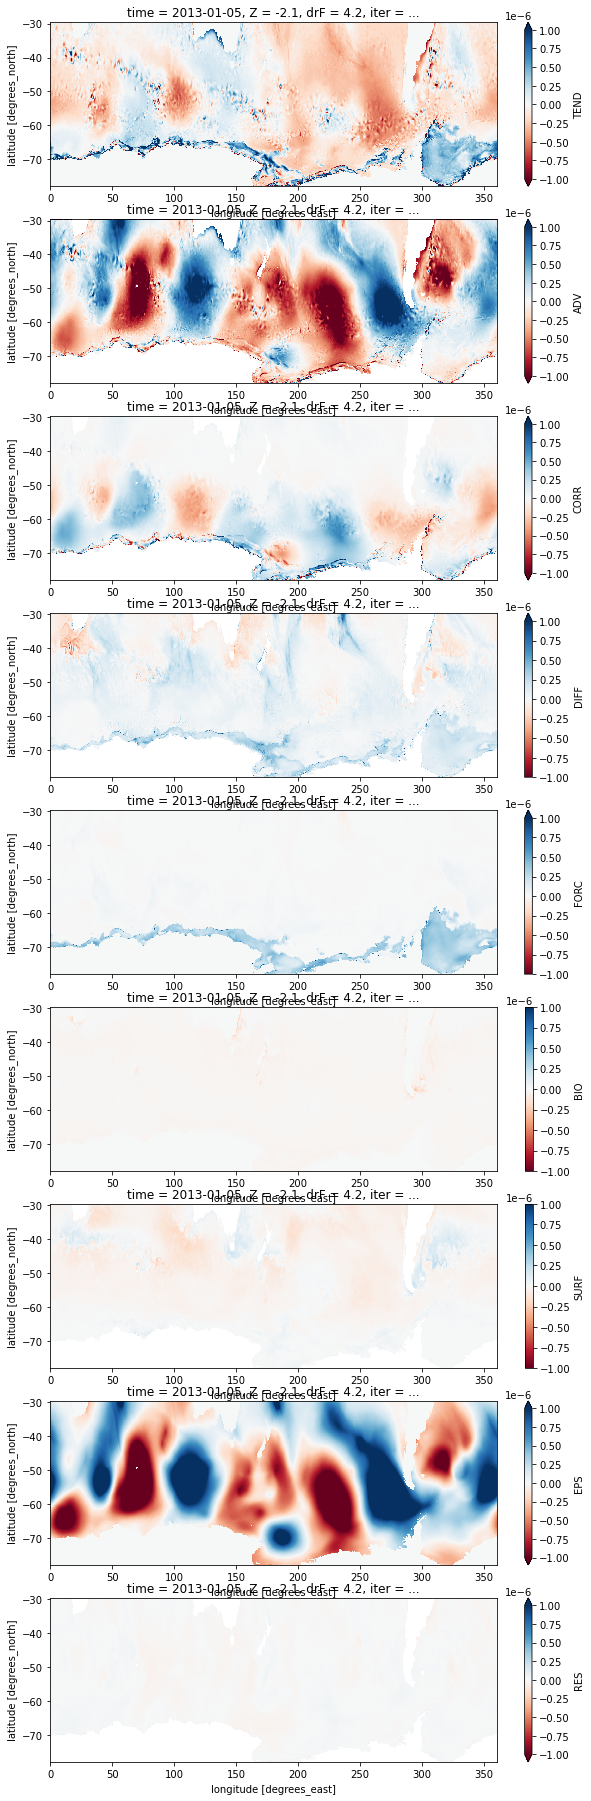

In [19]:
terms = ['TEND','ADV','CORR','DIFF','FORC','BIO','SURF','EPS']
select = {'time':0,'Z':0}
kwargs = {'vmin':-1E-6,'vmax':1E-6,'cmap':'RdBu'}
nt = len(terms)
fig,axarr=plt.subplots(figsize=(10,4*nt),nrows=len(terms)+1)
RES = xr.zeros_like(budget[terms[0]].isel(select))
RES.name = 'RES'
for i,term in enumerate(terms):
    ax=axarr.flat[i]
    budget[term].isel(select).plot(ax=ax,**kwargs)
    RES += signs[term]*budget[term].isel(select)
ax=axarr.flat[-1]    
RES.plot(ax=ax,**kwargs)#vmin=kwargs['vmin']*1E-2,vmax=kwargs['vmax']*1E-2,cmap=kwargs['cmap'])

### Spatial integrals

In [20]:
budgetint = (budget*ds['rA']).sel({'YC':slice(-90,-65)}).sum(['XC','YC','Z'])

TEND
2013-01-05T00:00:00.000000000
2013-01-10T00:00:00.000000000
2013-01-15T00:00:00.000000000
2013-01-20T00:00:00.000000000
2013-01-25T00:00:00.000000000
2013-01-30T00:00:00.000000000
2013-02-04T00:00:00.000000000
2013-02-09T00:00:00.000000000
2013-02-14T00:00:00.000000000
2013-02-19T00:00:00.000000000
2013-02-24T00:00:00.000000000
2013-03-01T00:00:00.000000000
2013-03-06T00:00:00.000000000
2013-03-11T00:00:00.000000000
2013-03-16T00:00:00.000000000
2013-03-21T00:00:00.000000000
2013-03-26T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-04-05T00:00:00.000000000
2013-04-10T00:00:00.000000000
2013-04-15T00:00:00.000000000
2013-04-20T00:00:00.000000000
2013-04-25T00:00:00.000000000
2013-04-30T00:00:00.000000000
2013-05-05T00:00:00.000000000
2013-05-10T00:00:00.000000000
2013-05-15T00:00:00.000000000
2013-05-20T00:00:00.000000000
2013-05-25T00:00:00.000000000
2013-05-30T00:00:00.000000000
2013-06-04T00:00:00.000000000
2013-06-09T00:00:00.000000000
2013-06-14T00:00:00.000000000
2013-

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


2013-01-10T00:00:00.000000000
2013-01-15T00:00:00.000000000
2013-01-20T00:00:00.000000000
2013-01-25T00:00:00.000000000
2013-01-30T00:00:00.000000000
2013-02-04T00:00:00.000000000
2013-02-09T00:00:00.000000000
2013-02-14T00:00:00.000000000
2013-02-19T00:00:00.000000000
2013-02-24T00:00:00.000000000
2013-03-01T00:00:00.000000000
2013-03-06T00:00:00.000000000
2013-03-11T00:00:00.000000000
2013-03-16T00:00:00.000000000
2013-03-21T00:00:00.000000000
2013-03-26T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-04-05T00:00:00.000000000
2013-04-10T00:00:00.000000000
2013-04-15T00:00:00.000000000
2013-04-20T00:00:00.000000000
2013-04-25T00:00:00.000000000
2013-04-30T00:00:00.000000000
2013-05-05T00:00:00.000000000
2013-05-10T00:00:00.000000000
2013-05-15T00:00:00.000000000
2013-05-20T00:00:00.000000000
2013-05-25T00:00:00.000000000
2013-05-30T00:00:00.000000000
2013-06-04T00:00:00.000000000
2013-06-09T00:00:00.000000000
2013-06-14T00:00:00.000000000
2013-06-19T00:00:00.000000000
2013-06-24

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


2013-01-10T00:00:00.000000000
2013-01-15T00:00:00.000000000
2013-01-20T00:00:00.000000000
2013-01-25T00:00:00.000000000
2013-01-30T00:00:00.000000000
2013-02-04T00:00:00.000000000
2013-02-09T00:00:00.000000000
2013-02-14T00:00:00.000000000
2013-02-19T00:00:00.000000000
2013-02-24T00:00:00.000000000
2013-03-01T00:00:00.000000000
2013-03-06T00:00:00.000000000
2013-03-11T00:00:00.000000000
2013-03-16T00:00:00.000000000
2013-03-21T00:00:00.000000000
2013-03-26T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-04-05T00:00:00.000000000
2013-04-10T00:00:00.000000000
2013-04-15T00:00:00.000000000
2013-04-20T00:00:00.000000000
2013-04-25T00:00:00.000000000
2013-04-30T00:00:00.000000000
2013-05-05T00:00:00.000000000
2013-05-10T00:00:00.000000000
2013-05-15T00:00:00.000000000
2013-05-20T00:00:00.000000000
2013-05-25T00:00:00.000000000
2013-05-30T00:00:00.000000000
2013-06-04T00:00:00.000000000
2013-06-09T00:00:00.000000000
2013-06-14T00:00:00.000000000
2013-06-19T00:00:00.000000000
2013-06-24

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


2013-01-10T00:00:00.000000000
2013-01-15T00:00:00.000000000
2013-01-20T00:00:00.000000000
2013-01-25T00:00:00.000000000
2013-01-30T00:00:00.000000000
2013-02-04T00:00:00.000000000
2013-02-09T00:00:00.000000000
2013-02-14T00:00:00.000000000
2013-02-19T00:00:00.000000000
2013-02-24T00:00:00.000000000
2013-03-01T00:00:00.000000000
2013-03-06T00:00:00.000000000
2013-03-11T00:00:00.000000000
2013-03-16T00:00:00.000000000
2013-03-21T00:00:00.000000000
2013-03-26T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-04-05T00:00:00.000000000
2013-04-10T00:00:00.000000000
2013-04-15T00:00:00.000000000
2013-04-20T00:00:00.000000000
2013-04-25T00:00:00.000000000
2013-04-30T00:00:00.000000000
2013-05-05T00:00:00.000000000
2013-05-10T00:00:00.000000000
2013-05-15T00:00:00.000000000
2013-05-20T00:00:00.000000000
2013-05-25T00:00:00.000000000
2013-05-30T00:00:00.000000000
2013-06-04T00:00:00.000000000
2013-06-09T00:00:00.000000000
2013-06-14T00:00:00.000000000
2013-06-19T00:00:00.000000000
2013-06-24

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


2013-01-10T00:00:00.000000000
2013-01-15T00:00:00.000000000
2013-01-20T00:00:00.000000000
2013-01-25T00:00:00.000000000
2013-01-30T00:00:00.000000000
2013-02-04T00:00:00.000000000
2013-02-09T00:00:00.000000000
2013-02-14T00:00:00.000000000
2013-02-19T00:00:00.000000000
2013-02-24T00:00:00.000000000
2013-03-01T00:00:00.000000000
2013-03-06T00:00:00.000000000
2013-03-11T00:00:00.000000000
2013-03-16T00:00:00.000000000
2013-03-21T00:00:00.000000000
2013-03-26T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-04-05T00:00:00.000000000
2013-04-10T00:00:00.000000000
2013-04-15T00:00:00.000000000
2013-04-20T00:00:00.000000000
2013-04-25T00:00:00.000000000
2013-04-30T00:00:00.000000000
2013-05-05T00:00:00.000000000
2013-05-10T00:00:00.000000000
2013-05-15T00:00:00.000000000
2013-05-20T00:00:00.000000000
2013-05-25T00:00:00.000000000
2013-05-30T00:00:00.000000000
2013-06-04T00:00:00.000000000
2013-06-09T00:00:00.000000000
2013-06-14T00:00:00.000000000
2013-06-19T00:00:00.000000000
2013-06-24

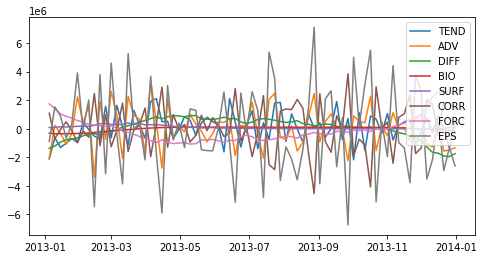

In [36]:
nt = 73
tmp = np.ndarray(shape=(nt,))
times = ds['time'].isel(time=slice(0,nt))

fig,ax = plt.subplots(figsize=(8,4))
for term in budgetint.data_vars:
    print(term)
    for i,t in enumerate(times):
        print(t.values)
        tmp[i] = budgetint[term].sel(time=t).values
    ax.plot(times,tmp,label=term)
ax.legend()